In [1]:
import pandas as pd
import os
from datasets import load_dataset

/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
DATA_SUCCESS_RATE_CONFIGS = {
    "MATH": {
        "loading_strategy": "local",
        "path": "../predicting_learnability/data/LOCAL/MATH",
        "splits": ["train", "test"],
        "prompt_col": "problem",
        "answer_col": "answer",
        "prompt_template": "{problem} Let's think step by step and output the final answer after \\boxed{{}}."
    },
    "GSM8K": {
        "loading_strategy": "HF",
        "path": "openai/gsm8k",
        "subset": "main",
        "splits": ["train", "test"],
        "prompt_col": "question",
        "answer_col": "answer",
        "prompt_template": "{question} Let's think step by step and output the final answer after \\boxed{{}}."
    }
}

In [14]:
MATH_CONFIG = DATA_SUCCESS_RATE_CONFIGS["MATH"]
GSM8K_CONFIG = DATA_SUCCESS_RATE_CONFIGS["GSM8K"]

In [15]:
MATH_PATH = MATH_CONFIG["path"]

In [33]:
MATH_train_df = pd.read_json(f"{MATH_PATH}/train.jsonl", lines=True)
MATH_test_df = pd.read_json(f"{MATH_PATH}/test.jsonl", lines=True)

MATH_train_df["question"] = MATH_train_df["problem"]
MATH_test_df["question"] = MATH_test_df["problem"]

MATH_train_df = MATH_train_df[["question", "answer"]]
MATH_test_df = MATH_test_df[["question", "answer"]]

In [34]:
ds = load_dataset(GSM8K_CONFIG["path"], GSM8K_CONFIG["subset"] )
for ds_split in ds.keys():
    extracted_answers = [
        item["answer"].split("\n####")[-1].strip() 
        for item in ds[ds_split]
    ]
    ds[ds_split] = ds[ds_split].map(
        lambda x, idx: {"answer": extracted_answers[idx]}, 
        with_indices=True
    )
GSM8K_train_df = ds["train"].to_pandas()
GSM8K_test_df = ds["test"].to_pandas()

In [37]:
# Determine the minimum size between MATH and GSM8K for each split
min_train_size = min(len(MATH_train_df), len(GSM8K_train_df))
min_test_size = min(len(MATH_test_df), len(GSM8K_test_df))

# Sample equal amounts from each dataset
MATH_train_balanced = MATH_train_df.sample(n=min_train_size, random_state=42)
GSM8K_train_balanced = GSM8K_train_df.sample(n=min_train_size, random_state=42)

MATH_test_balanced = MATH_test_df.sample(n=min_test_size, random_state=42)
GSM8K_test_balanced = GSM8K_test_df.sample(n=min_test_size, random_state=42)

# Combine balanced datasets
combined_train_df = pd.concat([MATH_train_balanced, GSM8K_train_balanced], ignore_index=True)
combined_test_df = pd.concat([MATH_test_balanced, GSM8K_test_balanced], ignore_index=True)

# Add dataset source column
combined_train_df['dataset_source'] = ['MATH'] * min_train_size + ['GSM8K'] * min_train_size
combined_test_df['dataset_source'] = ['MATH'] * min_test_size + ['GSM8K'] * min_test_size

print(f"Combined train split: {len(combined_train_df)} samples ({min_train_size} each)")
print(f"Combined test split: {len(combined_test_df)} samples ({min_test_size} each)")

Combined train split: 14946 samples (7473 each)
Combined test split: 1000 samples (500 each)


In [47]:
SAVE_DIR = "../predicting_learnability/data/LOCAL/MATH_X_GSM8K"
os.makedirs(SAVE_DIR, exist_ok=True)

In [49]:
combined_train_df.to_json(f"{SAVE_DIR}/train.jsonl", orient='records', lines=True)
combined_test_df.to_json(f"{SAVE_DIR}/test.jsonl", orient='records', lines=True)

In [ ]:
actual_path = "/VData/linna4335/llms_know_difficult/predicting_learnability/data/SR_DATASETS/MATH_X_GSM8K/Qwen2.5-1.5B-Instruct-SR_train_max_3000_k_1_temp_0.0.parquet"

current_file_path = "/VData/linna4335/llms_know_difficult/predicting_learnability/data/SR_DATASETS/MATH_X_GSM8K/Qwen2.5-Math-1.5B-Instruct-SR_train_max_3000_k_1_temp_0.0.parquet"

In [57]:
processed_df = pd.read_parquet("/VData/linna4335/llms_know_difficult/predicting_learnability/data/SR_DATASETS/MATH_X_GSM8K/Qwen2.5-1.5B-Instruct-SR_train_max_3000_k_1_temp_0.0.parquet")

In [59]:
processed_df["success_rate"].mean()

0.7203265087648869

<Axes: >

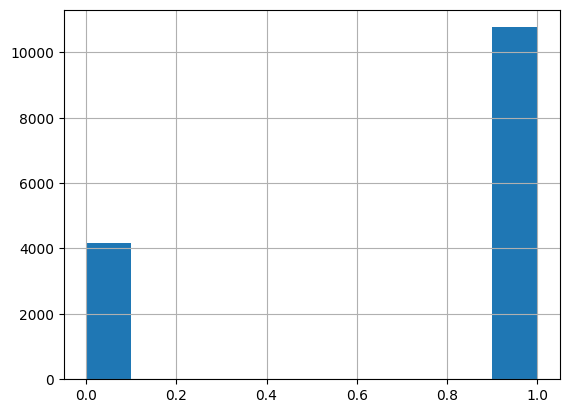

In [58]:
processed_df["success_rate"].hist()